In [1]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os

In [2]:
MODEL_PATH = "/content/cnn_model.h5"
model = load_model(MODEL_PATH)

In [4]:
IMG_SIZE = (224, 224)
def preprocess_image(image_path):
    img = load_img(image_path, target_size=IMG_SIZE)
    img_array = img_to_array(img)
    img_array = img_array / 255.0
    return np.expand_dims(img_array, axis=0)

In [5]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap) + 1e-8
    return heatmap.numpy()

In [6]:
path = "/content/person302_bacteria_1430.jpeg"

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Prediction score: 0.5705345
Predicted class: PNEUMONIA


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


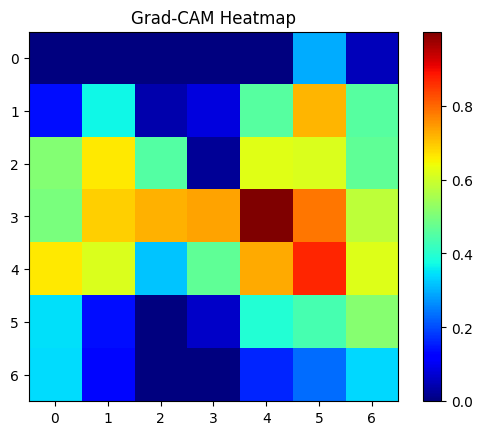

In [7]:
img_array = preprocess_image(path)
prediction = model.predict(img_array)[0][0]

print("Prediction score:", prediction)
print("Predicted class:", "PNEUMONIA" if prediction > 0.5 else "NORMAL")

LAST_CONV_LAYER = "Conv_1"  # MobileNetV2
heatmap = make_gradcam_heatmap(img_array, model, LAST_CONV_LAYER)

plt.imshow(heatmap, cmap="jet")
plt.colorbar()
plt.title("Grad-CAM Heatmap")
plt.show()

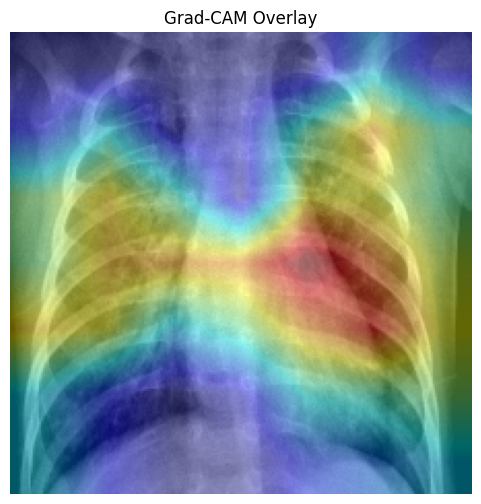

In [8]:
img = cv2.imread(path)
img = cv2.resize(img, IMG_SIZE)

heatmap_resized = cv2.resize(heatmap, IMG_SIZE)
heatmap_colored = cv2.applyColorMap(
    np.uint8(255 * heatmap_resized),
    cv2.COLORMAP_JET
)

overlay = cv2.addWeighted(img, 0.6, heatmap_colored, 0.4, 0)

plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Grad-CAM Overlay")
plt.show()